In [81]:
import gc
import os
from Project2_LSTM.load_data import AudioTrainDataset, PaddingZeros, CustomSpectogram

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_directml
from IPython.display import Audio
from torch.utils.data import DataLoader
from torchaudio.transforms import Spectrogram
from torchvision.transforms import Compose
from tqdm import tqdm

In [55]:
if not torch.cuda.is_available():
    device = torch_directml.device()
else:
    device = torch.device("cuda")

DATA_PATH = os.path.join("tensorflow-speech-recognition-challenge", "train", "audio")

In [57]:
dataset = AudioTrainDataset(DATA_PATH)
(wave, sample_rate), label = dataset[3456]

In [58]:
labels_list, labels_dict = dataset.find_classes(DATA_PATH)
labels_dict = {idx: name for name, idx in labels_dict.items()}
labels_dict

{1: 'bed',
 2: 'bird',
 3: 'cat',
 4: 'dog',
 5: 'down',
 6: 'eight',
 7: 'five',
 8: 'four',
 9: 'go',
 10: 'happy',
 11: 'house',
 12: 'left',
 13: 'marvin',
 14: 'nine',
 15: 'no',
 16: 'off',
 17: 'on',
 18: 'one',
 19: 'right',
 20: 'seven',
 21: 'sheila',
 22: 'six',
 23: 'stop',
 24: 'three',
 25: 'tree',
 26: 'two',
 27: 'up',
 28: 'wow',
 29: 'yes',
 30: 'zero'}

In [59]:
wave.shape

torch.Size([1, 16000])

In [60]:
label

3

Text(0.5, 1.0, 'Example wavefile for class cat')

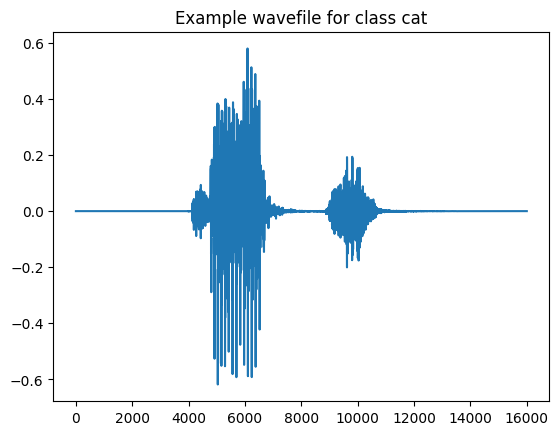

In [6]:
plt.plot(wave[0].numpy())
plt.title(f"Example wavefile for class {labels_dict[label]}")

In [7]:
Audio(wave, rate=sample_rate)

## Padding with 0 for constant length

Not all samples have equal length. 6469 samples are shorter than 16 000 points, other are exactly equal 16 000.

In [8]:
sizes = [0] * (len(dataset) // 20)
for i in tqdm(range((len(dataset) // 20))):
    sizes[i] = dataset[i][0][0][0].shape

100%|██████████| 3236/3236 [00:01<00:00, 1677.61it/s]


In [9]:
s, counts = np.unique([sizes], return_counts=True)

In [10]:
s[-1], sum(counts[:-1])

(16000, 418)

In [11]:
pad = PaddingZeros(16000)
sizes = [0] * (len(dataset) // 20)
for i in tqdm(range(len(dataset)//20)):
    sizes[i] = pad(dataset[i][0])[0][0].shape

100%|██████████| 3236/3236 [00:02<00:00, 1493.36it/s]


In [12]:
np.unique(sizes)

array([16000])

## Transformations

Plotting and transformations of a sample.

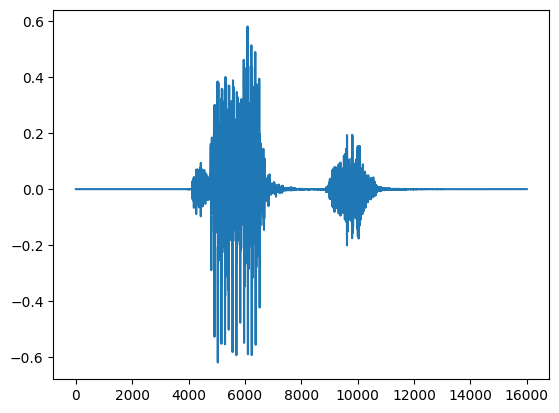

In [13]:
plt.plot(wave[0].numpy())

In [14]:
spect = torch.log(Spectrogram(n_fft=1024, power=2)(wave))
spect.shape

torch.Size([1, 513, 32])

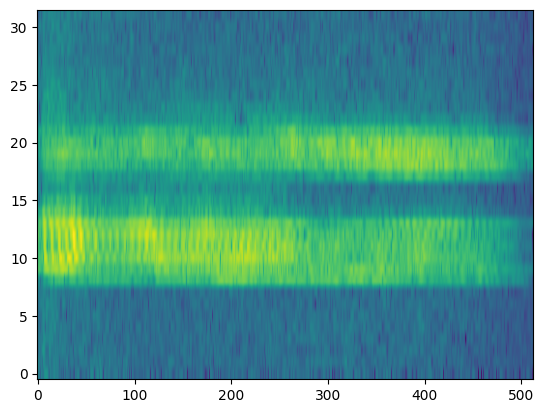

In [15]:
plt.imshow(spect[0].numpy().T, aspect='auto', origin='lower')

## Simple LSTM model

In [76]:
transforms = Compose([
    PaddingZeros(16000),
    CustomSpectogram(n_fft=1024, power=2)
])
features_dataset = AudioTrainDataset(DATA_PATH, transform=transforms)

In [90]:
data_loader = DataLoader(features_dataset, batch_size=72, num_workers=2, shuffle=True, generator=torch.random.manual_seed(123))

In [91]:
for (wave, sample_rate), label in data_loader:
    print(torch.squeeze(wave).shape)
    break

torch.Size([72, 513, 32])


In [92]:
class MyLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, target_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers=1)
        self.hidden2label = torch.nn.Linear(hidden_size, target_size)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self, x):
        x_transposed = torch.permute(x.squeeze(), (1, 0, 2))
        lstm_out, _ = self.lstm(x_transposed)
        label_space = self.hidden2label(lstm_out[-1])
        return self.softmax(label_space)

In [93]:
len(data_loader)

899

In [94]:
model = MyLSTM(32, 32, 30).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    for batch_no, ((wave, sample_rate), label) in tqdm(enumerate(data_loader)):
        model.zero_grad()
        y = torch.nn.functional.one_hot(label - 1, 30).to(torch.float32).to(device)
        y_hat = model(wave.to(device))

        l = loss(y_hat, y)
        l.backward()
        optimizer.step()

899it [34:53,  2.33s/it]
86it [03:20,  2.33s/it]


KeyboardInterrupt: 

In [97]:
wave=1

In [99]:
gc.collect()

0

[0.01664000004529953,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.016896000131964684,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 